# Ch11. 텍스트 분류 (Text Classification)

# v02. 스팸 메일 분류하기 (Spam Detection)

- 이번 챕터에서는 캐글에서 제공하는 정상 메일과 스팸 메일이 섞여져 있는 스팸 메일 데이터를 가지고 데이터에 대한 전처리를 진행하고 바닐라 RNN(Vanilla RNN)을 이용한 스팸 메일 분류기를 구현한다.

<br>

## 2.1 스팸 메일 데이터에 대한 이해

- [다운로드 링크](https://www.kaggle.com/uciml/sms-spam-collection-dataset)

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
data = pd.read_csv("spam.csv", encoding="latin1")

In [5]:
# 총 샘플의 수 확인
print('총 샘플의 수 : ', len(data))

총 샘플의 수 :  5572


In [6]:
# 상위 5개 샘플 출력
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


<br>

### 2.1.1 데이터셋 구성 확인

- 이 데이터에는 총 5개의 열이 있다.
- 여기서 `Unnamed`라는 이름의 3개의 열은 텍스트 분류를 할 때 불필요한 열이다.
- `v1`열은 해당 메일이 스팸인지 아닌지를 나타내는 레이블에 해당되는 열이다.
  - `ham`은 정상 메일을 의미
  - `spam`은 스팸 메일을 의미  


- `v2`열은 메일의 본문을 담고있다.

<br>

### 2.1.2 불필요한 열 제거 및 레이블 정수 인코딩

- 레이블과 메일 내용이 담긴 `v1`열과 `v2`열만 필요하므로, `Unnamed: 2`, `Unnamed: 3`, `Unnamed: 4` 열은 삭제한다.
- 또한, `v1`열에 있는 `ham`과 `spam` 레이블을 각각 숫자 `0`과 `1`로 바꾼다.

In [ ]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

data['v1'] = data['v1'].replace(['ham','spam'], [0, 1])

In [8]:
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


- 불필요한 열이 제거되고, v1열의 값이 숫자로 변환된 것을 확인할 수 있다.

<br>

### 2.1.3 데이터셋 열 타입 확인

- 해당 `data`의 정보를 확인해보자.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


- `v1`열은 정수형, `v2`열은 문자열 데이터를 갖고있다.

<br>

### 2.1.4 결측값 확인

- 혹시 Null 값을 가진 샘플이 있는 지 확인해보자.

In [10]:
data.isnull().values.any()

False

- `False`는 별도의 Null 값은 없음을 의미한다.
- 초기 데이터에 `Unnamed: 2`, `Unnamed: 3`, `Unnamed: 4`열에는 NaN이 있었는데 해당 상태에서 수행하는 `isnull().values.any()`는 `True`를 리턴한다.

<br>

### 2.1.5 중복 데이터 확인 및 제거

- Null 값이 없다면 혹시 데이터에 중복이 있지는 않은 지 확인해보자.

In [11]:
data['v2'].nunique()

5169

- 총 5,572개의 샘플이 존재하는 데 `v2`열에서 중복을 제거한 샘플의 개수가 5,169개라는 것은 403개의 중복 샘플이 존재한다는 의미이다.

In [12]:
data['v1'].nunique()

2

- `v1`열은 0 또는 1의 값만을 가지므로 2가 출력되었다.

<br>

- 중복 샘플을 제거해보자.

In [ ]:
# v2 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['v2'], inplace=True)

In [14]:
print('총 샘플의 수 : ', len(data))

총 샘플의 수 :  5169


- 총 샘플의 수가 5,572개에서 5,169개로 줄었다.

<br>

### 2.1.6 레이블 값의 분포 시각화

- 이제 스팸 메일 유무를 의미하는 레이블 값의 분포를 시각화해보자.

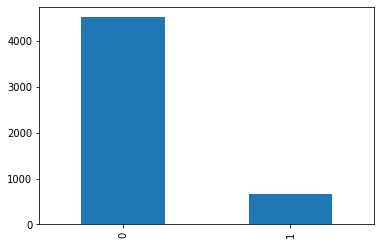

In [15]:
data['v1'].value_counts().plot(kind='bar')
plt.show()

- 레이블이 대부분 0에 편중되어 있다.
- 이는 스팸 메일 데이터의 대부분의 메일이 정상 메일임을 의미한다.

- 수치로 이를 확인해보자.

In [16]:
print(data.groupby('v1').size().reset_index(name='count'))

   v1  count
0   0   4516
1   1    653


- 레이블 0은 총 4,516개가 존재하고 1은 653개가 존재한다.

<br>

### 2.1.7 X와 y 분리

- 이제 X와 y를 분리한다.
- `v2`열을 X, `v1`열을 y로 저장한다.

In [17]:
X_data = data['v2']
y_data = data['v1']

print('메일 본문의 개수 : {}'.format(len(X_data)))
print('레이블의 개수 : {}'.format(len(y_data)))

메일 본문의 개수 : 5169
레이블의 개수 : 5169


- 이제 메일의 본문은 `X_data`에 각 메일의 본문에 대한 `1`과 `0`의 값을 가진 레이블은 `y_data`에 저장하였다.
- 개수는 둘 다 5,169개이다.

<br>

### 2.1.8 토큰화 및 정수 인코딩

- 이제 케라스 토크나이저를 통해 토큰화와 정수 인코딩 과정을 수행해보자.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장

- `sequences`에는 `X_data`의 단어들이 각 단어에 맵핑되는 정수로 인코딩되어 저장되었다.

- 5,169개의 메일이 있으나, 5개의 메일만 출력해서 확인해보겠습니다.

In [19]:
print(sequences[:5])

[[47, 433, 4013, 780, 705, 662, 64, 8, 1202, 94, 121, 434, 1203, 142, 2712, 1204, 68, 57, 4014, 137], [49, 306, 1364, 435, 6, 1767], [53, 537, 8, 20, 4, 1016, 934, 2, 220, 2713, 1365, 706, 2714, 2715, 267, 2716, 70, 2713, 2, 2717, 2, 359, 537, 604, 1205, 82, 436, 185, 707, 437, 4015], [6, 226, 152, 23, 347, 2718, 6, 138, 145, 56, 152], [935, 1, 97, 96, 69, 453, 2, 877, 69, 1768, 198, 105, 438]]


- 각 메일에는 단어가 아니라 단어에 대한 인덱스가 부여된 것을 확인할 수 있다.

- 각 정수가 어떤 단어에 부여되었는 지 확인해보자.

In [ ]:
word_to_index = tokenizer.word_index
print(word_to_index)

```
{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'call': 16, 'have': 17, 'on': 18, '2': 19, 'that': 20, 'now': 21, 'are': 22, 'so': 23, 'but': 24, 'not': 25, 'or': 26, 'do': 27, 'can': 28, 'at': 29, "i'm": 30, 'get': 31, 'be': 32, 'will': 33, 'if': 34, 'ur': 35, 'with': 36, 'just': 37, 'no': 38, 'we': 39, 'this': 40, 'gt': 41, '4': 42, 'lt': 43, 'up': 44, 'when': 45, 'ok': 46, 'free': 47, 'from': 48, 'how': 49, 'go': 50, 'all': 51, 'out': 52, - 이하 생략}
```

- `X_data`에 존재하는 모든 단어와 부여된 인덱스를 리턴한다.
- 위에서 부여된 각 정수는 각 단어의 빈도수가 높을 수록 낮은 정수가 부여됐다.
- 다시 말해, 단어 `i`는 현재 전체 훈련 데이터에서 빈도수가 가장 높은 단어이다.

<br>

### 2.1.9 각 단어의 등장 빈도수 확인

- 각 단어에 대한 등장 빈도수는 `tokenizer.word_counts().items()`를 출력해서 확인할 수 있다.

In [ ]:
tokenizer.word_counts.items()

```
odict_items([('go', 271), ('until', 27), ('jurong', 1), ('point', 13), ('crazy', 15), ('available', 16), ('only', 199), ('in', 826), ('bugis', 7), 이하 생략])
```

- 이를 응용하여 빈도수가 낮은 단어들이 훈련 데이터에서 얼만큼의 비중을 차지하는 지 확인해볼 수 있다.
- 등장 빈도수가 1회 밖에 되지 않는 단어들이 전체 단어 집합에서 얼만큼의 비율을 차지하며, 전체 훈련 데이터에서 등장 빈도로 얼만큼의 비율을 차지하는 지 확인해보자.

In [22]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈돗수가 threshold보다 작은 단어의 등장 빈도수의 총합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if (value < threshold): # 단어의 등장 빈도수가 threshold보다 작으면
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수 : %s' %(threshold - 1, rare_cnt))
print('단어 집합(vocabulary)에서 희귀 단어의 비율 : ', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : ', (rare_freq / total_freq) * 100)

등장 빈도가 1번 이하인 희귀 단어의 수 : 4908
단어 집합(vocabulary)에서 희귀 단어의 비율 :  55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :  6.082538108811501


- 등장 빈도가 `threshold` 값인 2회 미만. 즉, 1회 밖에 되지 않는 단어들은 단어 집합에서 무려 절반 이상을 차지한다.
- 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 6%밖에 되지 않는다.
- 만약, 이러한 분석을 통해 등장 빈도가 지나치게 낮은 단어들은 자연어 처리에서 제외하고 싶다면 케라스 토크나이저 선언 시에 단어 집합의 크기를 제한할 수 있다. (정수 인코딩 챕터 참고)
- 가령, 아래의 코드로 등장 빈도가 1회인 단어들을 제외할 수 있을 것이다.

```python
tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)
```

- 하지만 이번 실습에서는 별도로 단어 집합의 크기를 제한하지는 않는다.

<br>

### 2.1.10 단어 집합의 크기

- 이제 단어 집합의 크기를 `vocab_size`에 저장한다.
- 주의할 점은 패딩을 위한 토큰인 0번 단어를 고려하여 +1을 해서 저장해주어야 한다는 점이다.

In [23]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기 : {}'.format((vocab_size)))

단어 집합의 크기 : 8921


- 단어 집합의 크기는 8,921이다.

<br>

### 2.1.11 훈련 데이터와 테스트 데이터 분리 비율 확인

- 이제 훈련 데이터와 테스트 데이터의 분리 비율을 정해보자.
- 여기서는 8:2로 한다.

In [24]:
n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 : ', n_of_train)
print('테스트 데이터의 개수 : ', n_of_test)

훈련 데이터의 개수 :  4135
테스트 데이터의 개수 :  1034


- 앞서 확인하였는 데 전체 메일의 개수는 5,169개이다.
- 이제 전체 메일 데이터에서 일부는 테스트 데이터로 분리해야 한다.
- 전체 데이터의 80%를 훈련용 데이터로, 20%를 테스트 데이터로 사용하고자 한다.
- 숫자를 계산해봤을 때 훈련 데이터는 4,135개, 테스트 데이터는 1,034개를 쓰도록 한다.
- 아직은 단순히 숫자를 계산만해본 것이고, 실제로 데이터를 나누지는 않는다.

<br>

### 2.1.12 메일 데이터 길이 분포 확인

- 직관적으로 변수를 기억하기 위해 `X_data`에 대해서 정수 인코딩된 결과인 `sequences`를 `X_data`로 변경하고, 전체 데이터에서 가장 길이가 긴 메일과 전체 메일 데이터의 길이 분포를 알아보도록 하자.

In [25]:
X_data = sequences

print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %d' % (sum(map(len, X_data)) / len(X_data)))

메일의 최대 길이 : 189
메일의 평균 길이 : 15


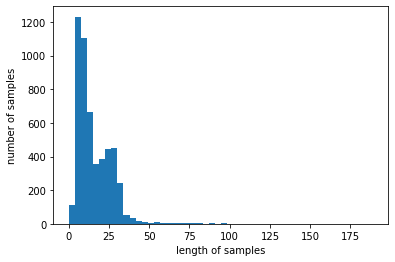

In [26]:
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 가장 긴 메일의 길이는 189이며, 전체 데이터의 길이 분포는 대체적으로 약 50이하의 길이를 가지는 것을 볼 수 있다.

<br>

### 2.1.13 데이터 패딩

In [27]:
max_len = 189

# 전체 데이터셋의 길이는 max_len으로 맞춘다.
data = pad_sequences(X_data, maxlen=max_len)
print('훈련 데이터의 크기 (shape) : ', data.shape)

훈련 데이터의 크기 (shape) :  (5169, 189)


- `pad_sequences()`의 `maxlen`에는 가장 긴 메일의 길이였던 189이라는 숫자를 넣었다.
- 이는 5,169개의 `X_data`의 길이를 전부189로 바꾼다.
- 189보다 길이가 짧은 메일 샘플은 전부 숫자 0이 패딩되어 189의 길이를 가지게 된다.

- 이제 `X_data` 데이터는 5,169 x 189 의 크기를 갖게 된다.
- 헷갈리지 말아야 할 것은 아직 `X_train`과 `X_test`를 분리하지 않았다는 것이다.

<br>

### 2.1.14 훈련 데이터와 테스트 데이터 분리

- 2 챕터의 데이터의 분리 챕터에서 배웠던 방법 중 하나로 훈련 데이터와 테스트 데이터를 분리해보자.

In [ ]:
X_test = data[n_of_train:] #X_data 데이터 중에서 뒤의 1034개의 데이터만 저장
y_test = np.array(y_data[n_of_train:]) #y_data 데이터 중에서 뒤의 1034개의 데이터만 저장
X_train = data[:n_of_train] #X_data 데이터 중에서 앞의 4135개의 데이터만 저장
y_train = np.array(y_data[:n_of_train]) #y_data 데이터 중에서 앞의 4135개의 데이터만 저장

<br>

## 2.2 RNN으로 스팸 메일 분류하기

- 이제 바닐라 RNN을 이용하여 스팸 메일 분류기를 만들어보도록 하자.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense

<br>

### 2.2.1 모델 훈련

- `Embedding()`은 두 개의 인자를 받는다.
  - 단어 집합의 크기, 임베딩 벡터의 차원이다.

- 이진 분류 문제이므로 마지막 출력층에는 1개의 뉴런과 활성화 함수로 시그모이드 함수를 사용한다.
- 손실 함수로는 `binary_crossentropy`를 사용한다.

- `validation_split=0.2`을 주어서 훈련 데이터의 20%를 검증 데이터로 나누고, 검증 데이터를 보면서 훈련이 제대로 되고 있는 지 확인해본다.
- 검증 데이터는 기계가 훈련 데이터에 과적합 되고 있지는 않은 지 확인하기 위한 용도로 사용된다.
- 총 4번 학습한다. (`epochs=4`)

In [30]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
52/52 [==============================] - 2s 46ms/step - loss: 0.3894 - acc: 0.8685 - val_loss: 0.3324 - val_acc: 0.8730
Epoch 2/4
52/52 [==============================] - 2s 42ms/step - loss: 0.1523 - acc: 0.9559 - val_loss: 0.1057 - val_acc: 0.9722
Epoch 3/4
52/52 [==============================] - 2s 42ms/step - loss: 0.0608 - acc: 0.9840 - val_loss: 0.0840 - val_acc: 0.9698
Epoch 4/4
52/52 [==============================] - 2s 42ms/step - loss: 0.0331 - acc: 0.9918 - val_loss: 0.0554 - val_acc: 0.9831


<br>

### 2.2.2 모델 평가

- 이제 테스트 데이터에 대해서 정확도를 확인해보자.

In [31]:
print('\n 테스트 정확도 : %.4f' % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 9ms/step - loss: 0.0506 - acc: 0.9845

 테스트 정확도 : 0.9845


<br>

### 2.2.3 훈련 데이터와 검증 데이터의 손실(loss) 시각화

- 이번 실습에서는 훈련 데이터와 검증 데이터에 대해서 같이 정확도를 확인하면서  훈련하였으므로, 이를 비교하여 그래프로 시각화해보자.

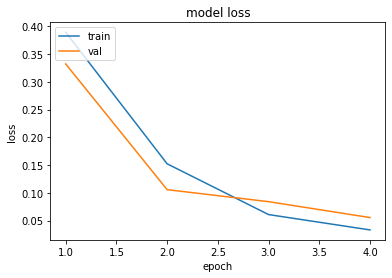

In [32]:
epochs = range(1, len(history.history['acc']) + 1)

plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

- 이번 실습 데이터는 데이터의 양이 적어 과적합이 빠르게 시작된다.
- 그러므로 검증 데이터에 대한 오차가 증가하기 시작하는 시점의 바로 직전인 에포트 3 ~ 4 정도가 적당하다.
- 이 데이터는 에포크 5를 넘어가기 시작하면 검증 데이터의 오차가 증가하는 경향이 있다.